In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from astropy.io import fits
import warnings
import pandas

warnings.filterwarnings('ignore')

In [ ]:
gaussian_11 = fits.open('/home/scratch/hfwest/Pilot/Results/11/Pilot_NH3_11_bl2_Vel11_single_component.fits')[0].data
gaussian_33 = fits.open('/home/scratch/hfwest/Pilot/Results/33/Pilot_NH3_33_bl2_Vel33.fits')[0].data


In [144]:
x, y = np.meshgrid(np.arange(gaussian_11.shape[1]), np.arange(gaussian_11.shape[0]))
mask_11 = np.copy(gaussian_11)
mask_33 = np.copy(gaussian_33)

for i in range(gaussian_11.shape[0]):
    for j in range(gaussian_33.shape[1]):
        if gaussian_11[i, j] < 50:
            mask_11[i, j] = np.nan
        if gaussian_33[i, j] < 50:
            mask_33[i, j] = np.nan

MovieWriter ffmpeg unavailable; using Pillow instead.


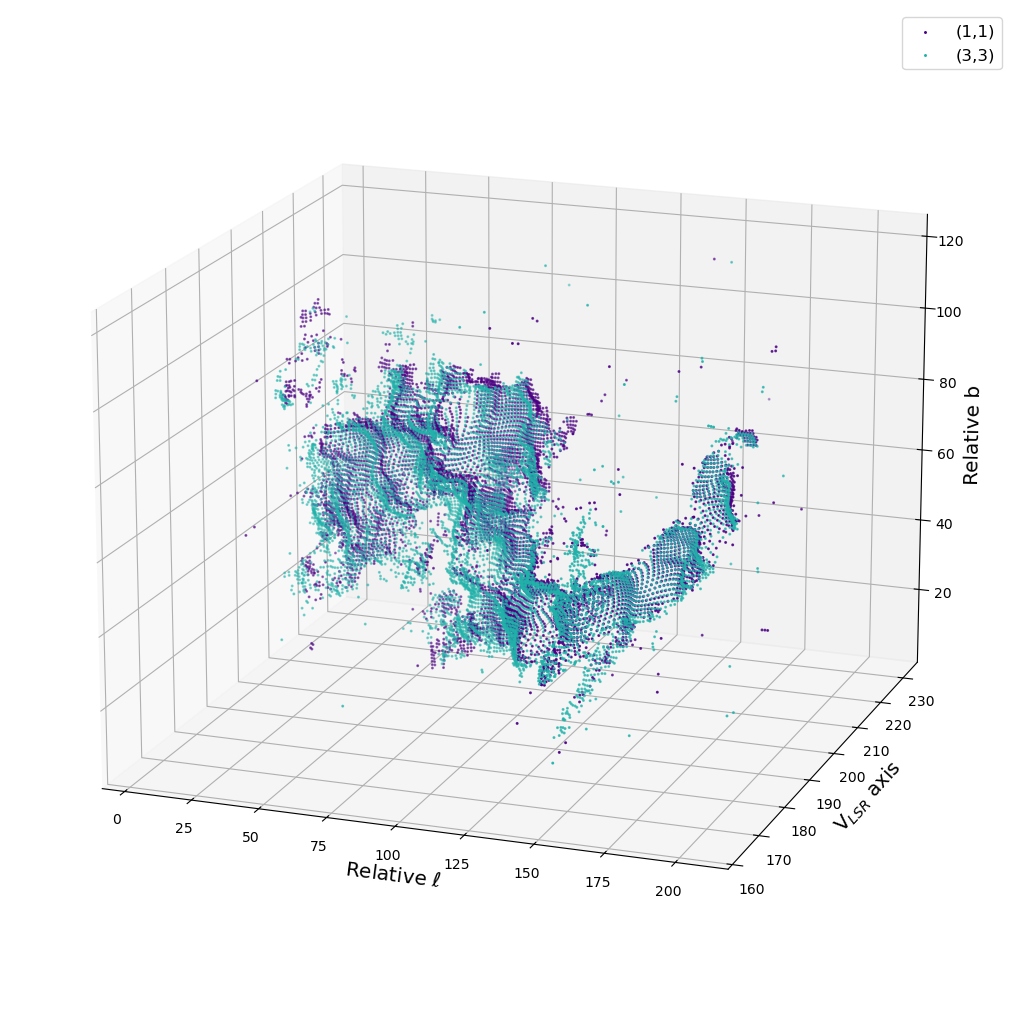

In [217]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
plt.tight_layout(pad = 0)

ax.scatter3D(x, mask_11, y, cmap = 'viridis', marker = '.', s = 5, label = '(1,1)', color = 'indigo')
ax.scatter3D(x, mask_33, y, cmap = 'viridis', marker = '.', s = 5, label = '(3,3)', color = 'lightseagreen')

ax.set_xlabel('Relative $\ell$', fontsize = 'x-large')
ax.set_zlabel('Relative b', fontsize = 'x-large')
ax.set_ylabel('V$_{LSR}$ axis', fontsize = 'x-large')
ax.legend(fontsize = 'large')

ax.set_ylim(160, 235)

ax.view_init(elev= 20, azim = -70)

def rotate(a):
    ax.view_init(elev = 17, azim = a)

anim = FuncAnimation(fig, rotate, frames = np.arange(-70, 290), interval = 30)
anim.save('/home/scratch/hfwest/Pilot/Results/Vel_rotation_11_33.gif')

# plt.show()